In [1]:
%load_ext autoreload
%autoreload 2

## Step 0: Set up the notebook

In [2]:
import warnings
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML

InteractiveShell.ast_node_interactivity = 'all'  # display full outputs in Jupyter
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14933613904855907303
]


## Step 1: Load data

In [4]:
import pandas as pd
import numpy as np

Textual data

In [5]:
data = pd.read_csv('../data/neural_network_patent_query.csv', parse_dates=['patent_date'])
data.head()

# Extract abstracts
original_abstracts = list(data['patent_abstract'])
len(original_abstracts)

,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


3522

## Step 2: Big Data Munging & Exploration

In [6]:
data['patent_abstract'][100]

'The present invention provides an apparatus and a method for classifying and recognizing image patterns using a second-order neural network, thereby achieving high-rate parallel processing while lowering the complexity. The second-order neural network, which is made of adders and multipliers, corrects positional translations generated in a complex-log mapping unit to output the same result for the same object irrespective of the scale and/or rotation of the object. The present invention enables high-rate image pattern classification and recognition based on parallel processing, which is the advantage obtained in neural network models, because consistent neural networks and consistent network structure computation models are applied to all steps from the image input step to the pattern classifying and recognizing step.'

Explore time series

Text(0,0.5,'Number of Patents')

Text(0.5,0,'Date')

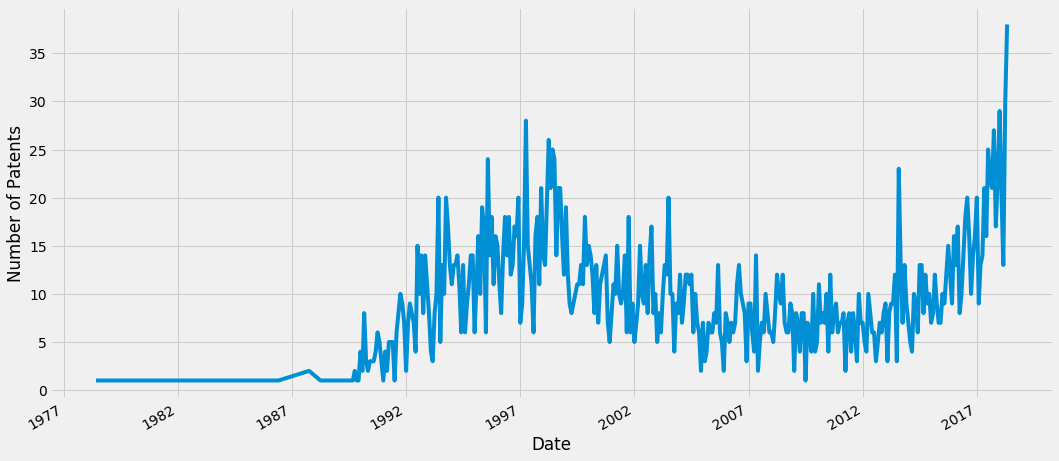

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')


data['year-month'] = [
    pd.datetime(year, month, 1) for year, month in zip(
        data['patent_date'].dt.year, data['patent_date'].dt.month)
]

monthly = data.groupby('year-month')['patent_abstract'].count().reset_index()

monthly.set_index('year-month')['patent_abstract'].plot(figsize=(16, 8))
plt.ylabel('Number of Patents')
plt.xlabel('Date')

## Step 3: convert word sequences to integer sequences

What is doing here includes:
- read csv as a pandas dataframe
- parse the patent_abstract column to a list and format sequence (add spaces around punctuation and remove spaces)
- make sequences by turning a set of texts into integers/index -> only keep sentences with more than training length tokens
- create train/valid split, random shuffle features and labels, labels are one-hot encoded

3. 1 Tokenization methods using tokenizer in keras

In [6]:
example = data['patent_abstract'][15]
example
len(example) # the length of example is a count of characters and punctuations

'Systems and methods using a neural network based portable absorption spectrometer system for real-time automatic evaluation of tissue injury are described. An apparatus includes an electromagnetic signal generator; an optical fiber connected to the electromagnetic signal generator; a fiber optic probe connected to the optical fiber; a broad band spectrometer connected to the fiber optic probe; and a hybrid neural network connected to the broad band spectrometer. The hybrid neural network includes a principle component analyzer of broad band spectral data obtained from said broad band spectrometer.'

604

In [7]:
from keras.preprocessing.text import Tokenizer
import re

Using TensorFlow backend.


In [8]:
def format_sequence(s):
    """Add spaces around punctuation and remove references to images/citations."""
    
    # Add spaces around punctuation
    s =  re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', s)
    
    # Remove references to figures
    s = re.sub(r'\((\d+)\)', r'', s)
    
    # Remove double spaces
    s = re.sub(r'\s\s', ' ', s)
    return s

In [9]:
format_ex = format_sequence(example)

In [10]:
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'  # choose to remove the punctuations
tokenizer = Tokenizer(lower = True, filters=filters)
tokenizer.fit_on_texts([example])

Tokenization, removes punctuation and generate a sequence of integers.

In [11]:
len(tokenizer.texts_to_sequences([example])[0]), len(example)

(88, 604)

In [12]:
tokenizer.fit_on_texts([format_ex])
len(tokenizer.texts_to_sequences([format_ex])[0]), len(format_ex)

(88, 611)

In [13]:
# using the reverse index to get original word and join them
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)

'systems and methods using a neural network based portable absorption spectrometer system for real time automatic evaluation of tissue injury are described an apparatus includes an electromagnetic signal generator an optical fiber connected to the electromagnetic signal generator a fiber optic probe connected to the optical fiber a broad band spectrometer connected to the fiber optic probe and a hybrid neural network connected to the broad band spectrometer the hybrid neural network includes a principle component analyzer of broad band spectral data obtained from said broad band spectrometer'

In [106]:
format_s = tokenizer.texts_to_sequences([format_ex])[0]
' '.join(tokenizer.index_word[i] for i in s)

'systems and methods using a neural network based portable absorption spectrometer system for real time automatic evaluation of tissue injury are described an apparatus includes an electromagnetic signal generator an optical fiber connected to the electromagnetic signal generator a fiber optic probe connected to the optical fiber a broad band spectrometer connected to the fiber optic probe and a hybrid neural network connected to the broad band spectrometer the hybrid neural network includes a principle component analyzer of broad band spectral data obtained from said broad band spectrometer'

In [14]:
#  word index
tokenizer.word_index.keys()
tokenizer.word_index

dict_keys(['a', 'the', 'spectrometer', 'fiber', 'connected', 'to', 'broad', 'band', 'neural', 'network', 'an', 'and', 'of', 'includes', 'electromagnetic', 'signal', 'generator', 'optical', 'optic', 'probe', 'hybrid', 'systems', 'methods', 'using', 'based', 'portable', 'absorption', 'system', 'for', 'real', 'time', 'automatic', 'evaluation', 'tissue', 'injury', 'are', 'described', 'apparatus', 'principle', 'component', 'analyzer', 'spectral', 'data', 'obtained', 'from', 'said'])

{'a': 1,
 'the': 2,
 'spectrometer': 3,
 'fiber': 4,
 'connected': 5,
 'to': 6,
 'broad': 7,
 'band': 8,
 'neural': 9,
 'network': 10,
 'an': 11,
 'and': 12,
 'of': 13,
 'includes': 14,
 'electromagnetic': 15,
 'signal': 16,
 'generator': 17,
 'optical': 18,
 'optic': 19,
 'probe': 20,
 'hybrid': 21,
 'systems': 22,
 'methods': 23,
 'using': 24,
 'based': 25,
 'portable': 26,
 'absorption': 27,
 'system': 28,
 'for': 29,
 'real': 30,
 'time': 31,
 'automatic': 32,
 'evaluation': 33,
 'tissue': 34,
 'injury': 35,
 'are': 36,
 'described': 37,
 'apparatus': 38,
 'principle': 39,
 'component': 40,
 'analyzer': 41,
 'spectral': 42,
 'data': 43,
 'obtained': 44,
 'from': 45,
 'said': 46}

## Step 4: Generate Training Data for the Model

Format sequence -> tokenize sequence -> generate sequences using training length -> train/test split of generated sequences -> output traing_dict (optional)

In [19]:
original_abstracts = list(data['patent_abstract'])

In [20]:
abstracts = [format_sequence(a) for a in original_abstracts]

In [17]:
def make_sequences(texts, training_length = 50,
                   lower = True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""
    
    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)
    
    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts
    
    print(f'There are {num_words} unique words.')
    
    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [i for i, l in enumerate(seq_lengths) if l > (training_length + 20)]
    
    new_texts = []
    new_sequences = []
    
    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])
        
    features = []
    labels = []
    
    # Iterate through the sequences of tokens
    for seq in new_sequences:
        
        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length: i + 1]
            
            # Set the features and label
            features.append(extract[:-1])
            labels.append(extract[-1])
    
    print(f'There are {len(features)} sequences.')
    
    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, features, labels

In [18]:
word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, features, labels = make_sequences(abstracts)

There are 11695 unique words.
There are 293001 sequences.


In [34]:
word_idx

{'the': 1,
 'a': 2,
 'of': 3,
 'and': 4,
 'to': 5,
 'network': 6,
 'neural': 7,
 'is': 8,
 'in': 9,
 'for': 10,
 'an': 11,
 'data': 12,
 'by': 13,
 'are': 14,
 'input': 15,
 'or': 16,
 'system': 17,
 'output': 18,
 'with': 19,
 'from': 20,
 'each': 21,
 'which': 22,
 'be': 23,
 'on': 24,
 'as': 25,
 'that': 26,
 'signal': 27,
 'one': 28,
 'method': 29,
 'image': 30,
 'at': 31,
 'using': 32,
 'plurality': 33,
 'based': 34,
 'first': 35,
 'layer': 36,
 'includes': 37,
 'set': 38,
 'can': 39,
 'training': 40,
 'control': 41,
 'processing': 42,
 'may': 43,
 'values': 44,
 'time': 45,
 'model': 46,
 'second': 47,
 'information': 48,
 'value': 49,
 'signals': 50,
 'learning': 51,
 'process': 52,
 'used': 53,
 'neuron': 54,
 'such': 55,
 'least': 56,
 'pattern': 57,
 'device': 58,
 'between': 59,
 'apparatus': 60,
 'vector': 61,
 'circuit': 62,
 'unit': 63,
 'having': 64,
 'more': 65,
 'function': 66,
 'into': 67,
 'neurons': 68,
 'trained': 69,
 'parameters': 70,
 'invention': 71,
 'provided

In [37]:
len(labels)

293001

In [52]:
list(enumerate(labels[:5]))

[(0, 1370), (1, 5), (2, 2), (3, 879), (4, 353)]

In [45]:
print(len(features[0])) # training_length

50 50


Let's see how the features and labels look like

In [114]:
def find_label(index):
    """Find label corresponding to features for index in training sequences"""
    feats = ' '.join(idx_word[i] for i in features[index])
    answer = idx_word[labels[index]]
    print('Features:', feats)
    print('Answer:', answer)

In [116]:
n = 3
find_label(n)

Features: enhances stability in a neural network system that when used as a track while scan system assigns sensor plots to predicted track positions in a plot track association situation the barometer neuron functions as a bench mark or reference system node that equates a superimposed plot and track to a
Answer: zero


In [122]:
original_abstracts[0]

'" A ""Barometer"" Neuron enhances stability in a Neural Network System that, when used as a track-while-scan system, assigns sensor plots to predicted track positions in a plot/track association situation. The ""Barometer"" Neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a zero distance as a ""perfect"" pairing of plot and track which has a measured/desired level of inhibition. The ""Barometer"" Neuron responds to the System inputs, compares these inputs against the level of inhibition of the ""perfect"" pair, and generates a supplied excitation or inhibition output signal to the System which adjusts the System to a desired value at or near 1.0; this the reference level of inhibition of the ""perfect"" pair. "'

In [123]:
find_label(10)

Features: that when used as a track while scan system assigns sensor plots to predicted track positions in a plot track association situation the barometer neuron functions as a bench mark or reference system node that equates a superimposed plot and track to a zero distance as a perfect pairing of
Answer: plot


**Deciding which pre-processing steps to take in general is the most important aspect of an machine learning project.**

Find out the most common word used in the training set.

Sorted is a nice function which takes an iterable (list, dict, etc.) and sort by a defined function: key.

In [146]:
sorted(word_counts.items(), key=lambda x:x[1], reverse=True)[:10]

[('the', 36614),
 ('a', 24904),
 ('of', 20240),
 ('and', 12968),
 ('to', 12150),
 ('network', 7829),
 ('neural', 7450),
 ('is', 7214),
 ('in', 7059),
 ('for', 6909)]

### 3. 2 create train/validate/test sets with sequences

Now we need to take the features and labels and conver them to training and validation data. The following functions does this by splitting the features and labels by a specified train fraction, after random shuffling because the features were made in sequential order.

All the inputs are conveted to numpy arrays which are the correct inputs to a keras network. Also, we do want to be careful about using up too much memory. One hot encoding the labels creates massive numpy arrays so I took care to delete the un-used objects from the workspace.

In [21]:
from sklearn.utils import shuffle
RANDOM_STATE = 50

In [22]:
def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=0.7):
    """Create training and validation features and labels."""
    
    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    # Memory management
    import gc   
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect() # garbage collection destoyred unneeded objects. https://rushter.com/blog/python-garbage-collector/ The main advantage of such approach is that the objects can be immediately destroyed after they are no longer needed.

    return X_train, X_valid, y_train, y_valid

In [23]:
X_train, X_valid, y_train, y_valid = create_train_valid(features, labels, num_words)

In [149]:
# create a dict for training / validation set
training_dict = {'X_train': X_train, 'X_valid': X_valid, 'y_train': y_train, 'y_valid': y_valid}

In [151]:
X_train.shape
X_valid.shape
y_train.shape
y_valid.shape

(205100, 50)

(87901, 50)

(205100, 11695)

(87901, 11695)

In [153]:
import sys
sys.getsizeof(y_train)/1e9

2.398644612

In [161]:
def check_sizes(gb_min=1):
    for x in globals():
        size = sys.getsizeof(eval(x)) / 1e9
        if size > gb_min:
            print(f'Object: {x} Size: {size} GB.')
            
check_sizes(gb_min=1)

Object: __ Size: 2.398644612 GB.
Object: y_train Size: 2.398644612 GB.
Object: y_valid Size: 1.028002307 GB.
Object: _159 Size: 2.398644612 GB.


Let's see how the training dict looks like.

In [111]:
id_sequence = 10
' '.join(idx_word[i] for i in training_dict['X_train'][id_sequence])

idx_word[np.argmax(training_dict['y_train'][10])]

'device or bipolar junction transistor and the balancing scheme are suitable for microfabrication and provides noise rejection enhancement the interconnected integral feedback of the autonulling dc bridge enables both a neural network for pre processing sensor input in a spatial domain as well as general analog computation that mimics a'

'first'

## Inference 

In [28]:
for i, sequence in enumerate(training_dict['X_train'][:6]):
    text = []
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text) + '\n')
    print('Label: ' + idx_word[np.argmax(training_dict['y_train'][i])] + '\n')

Features: user to provide samples . A recognition operation is performed on the user's handwritten input , and the user is not satisfied with the recognition result . The user selects an option to train the neural network on one or more characters to improve the recognition results . The user

Label: is

Features: and includes a number of amplifiers corresponding to the N bit output sum and a carry generation from the result of the adding process an augend input-synapse group , an addend input-synapse group , a carry input-synapse group , a first bias-synapse group a second bias-synapse group an output feedback-synapse

Label: group

Features: a set of physical parameters that fully define the smaller extraction problem . Next , models are created using machine learning techniques for all of the smaller simpler extraction problems . The machine learning is performed by first creating training data sets composed of the identified parameters from typical examples

Label: of

Features: no

## Make RNN 
- Embedding dimension = 100
- 64 LSTM cells in one layer
- Dropout and recurrent dropout for regularization
- Fully connected layer with 64 units on top of LSTM
- 'relu' activation
- Drop out for regularization
- Output layer produces prediction for each word
- 'softmax' activation
- Adam optimizer with defaults
- Categorical cross entropy loss
- Monitor accuracy

In [24]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

In [25]:
model = Sequential()

In [26]:
# Embedding layer
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True
    )
)

In [27]:
# Recurrent layer
model.add(
    LSTM(
    64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1
    )
)

In [28]:
# Fully Connected layer
model.add(
    Dense(64, activation='relu')
)

In [35]:
# Dropout for regularization
model.add(Dropout(0.5))

In [36]:
# Output layer
model.add(Dense(len(word_idx) + 1, activation='softmax'))

In [37]:
# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1619200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16192)             1052480   
Total params: 2,718,080
Trainable params: 2,718,080
Non-trainable params: 0
_________________________________________________________________


https://towardsdatascience.com/deploying-a-keras-deep-learning-model-as-a-web-application-in-p-fc0f2354a7ff 
https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
load word embeddings:https://gist.github.com/WillKoehrsen/93f2643f9596916b72888796cf2710e9#file-load_word_embeddings-py 

## Load in Pre-Trained Model

In [39]:
from keras.models import load_model

model = load_model('../models/train-embeddings-rnn.h5')

In [43]:
model.layers

In [46]:
model.fit(training_dict['X_train'], training_dict['y_train'], epochs=5, batch_size=2048,
         validation_data = (training_dict['X_valid'], training_dict['y_valid']),
          verbose=1
         )

Train on 222994 samples, validate on 95569 samples
Epoch 1/5
222994/222994 [==============================] - 290s 1ms/step - loss: 3.9993 - acc: 0.2685 - val_loss: 4.8002 - val_acc: 0.2587
Epoch 2/5
222994/222994 [==============================] - 290s 1ms/step - loss: 3.9010 - acc: 0.2782 - val_loss: 4.7813 - val_acc: 0.2626
Epoch 3/5
222994/222994 [==============================] - 289s 1ms/step - loss: 3.8536 - acc: 0.2832 - val_loss: 4.7653 - val_acc: 0.2644
Epoch 4/5
222994/222994 [==============================] - 274s 1ms/step - loss: 3.8195 - acc: 0.2874 - val_loss: 4.7604 - val_acc: 0.2657
Epoch 5/5
222994/222994 [==============================] - 273s 1ms/step - loss: 3.7951 - acc: 0.2889 - val_loss: 4.7596 - val_acc: 0.2666


In [47]:
model.evaluate(training_dict['X_train'], training_dict['y_train'], batch_size=2048)

222994/222994 [==============================] - 86s 386us/step


[3.2911469715245034, 0.3365561406180473]

## Generate output by starting it off with a seed consequence

In [136]:
# Choose a random sequence
import random
seq = random.choice(sequences)

In [137]:
# Choose a random starting point
seed_length = 50
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

In [138]:
# Extract the seed sequence
seed = seq[seed_idx:end_idx]
origina_sequence = [idx_word[i] for i in seed]
generated = seed[:] + ['#']

In [139]:
# Actual entire sequence
new_words = 30
actual = generated[:] + seq[end_idx:end_idx + new_words]

In [159]:
# Seq to seq, keep adding new words. 
# The diversity controls the amount of stochasticity in the predictions: the next word predicted is selected based on the probabilities of the predictions.
for i in range(new_words):
    
    # Make a prediction from the seed
    preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)
    exp_preds = np.exp(np.log(preds) / diversity)
    
    # Softmax 
    preds = exp_preds / sum(exp_preds)
    
    probas = np.random.multinomial(1, preds, 1)[0]
    
    next_idx = np.argmax(probas)
    
    seed += [next_idx]
    generated.append(next_idx)

/Users/szhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [161]:
# generated list
gen_list = []
n = []

for i in generated:
    n.append(idx_word.get(i, '< --- >'))

gen_list.append(n)

## Prediction


In [ ]:
s = 'This patent provides a basis for using a recurrent neural network to '


In [165]:
s = 'This patent provides a basis for using a recurrent neural network to '
HTML(seed_sequence(model, s, word_idx, idx_word, diversity = 0.75, num_words = 20))